# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил, что многие клиенты пользуются архивными тарифами. Им необходимо построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

Нам предстоит построить модель для задачи классификации, которая выберет подходящий тариф. В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы.

###### Данное исследование разделим на несколько этапов.

##### 1. Изучение общей информации:
* [1.1. Загрузка библиотек, изученеие файлов с данными, получение общей информации.](#section1)
* [1.2. Подготовка данных.](#section2)

##### 2. Разбиение данных на выборки:
* [2.1. Извлеченние в отдельные переменные признаки и целевой признак.](#section3)
* [2.2. Разделение набора данных на обучающую, валидационную, и тестовую выборку.](#section4)

##### 3. Исследование моделей:
* [3.1. Оценим качество трех моделей по умолчанию.](#section5)
* [3.2. Оценим качество моделей на тренировочной выборке.](#section6)
* [3.3. Улучшим модели.](#section7)
    * [Случайный лес (RandomForestClassifier).](#section8)
    * [Дерево решений (DecisionTreeClassifier).](#section9)
    * [Логистическая регрессия (LogisticRegression).](#section10)
* [3.4. Добавим получившиеся метрики в таблицу modl, и выберем лучшую модель.](#section11)

##### 4. Проверка модели на тестовой выборке:
* [4.1. Объединим тренировачную и валидационную выборки.](#section12)
* [4.2. Обучим модель на полных данных.](#section13)
* [4.3. Получим предсказания и посчитаем качество модели на тестовой выборке.](#section14)

##### 5. Проверка модели на адекватность:
* [5.1. Создадим константную модель.](#section15)
* [5.2. Сравним показатель точности константной модели и финальной.](#section16)

##### 6. Общий вывод:
* [6.1. Формулировка общего вывода.](#section17)

<a id='section1'></a>

## 1. Изучение общей информации

### 1.1.  Загрузка библиотек, изученеие файлов с данными, получение общей информации.

Импортируем все необходимые библиотеки.

In [1]:
import pandas as pd 
import numpy as np
import math

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

from sklearn.model_selection import GridSearchCV

import time

from sklearn.dummy import DummyClassifier

#### Прочитаем файл с данными.

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

#### Получим первые строки таблицы.

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


##### Описание данных
* сalls — количество звонков,
* minutes — суммарная длительность звонков в минутах,
* messages — количество sms-сообщений,
* mb_used — израсходованный интернет-трафик в Мб,
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

#### Изучим общую информацию таблицы.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


*Рассмотрим полученную информацию подробнее. Всего в таблице 5 столбцов и 3214 строк, присутствуют два разные типы данных. Количество значений в столбцах не различается. Это говорит о том, что в данных нет пропущенных значений.*

#### Изучим коэффициенты корреляции для всех столбцов.

In [5]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


*Как можно заметить из нашей матрицы, коррелируют между собой следующие столбцы calls и minutes. Таким образом мы обнаружили мультиколлинеарность. По этому один из параметров мы можем убрать из выборки. Данное действие не ухудшит качество наших моделей.*

In [6]:
df = df.drop(['minutes'], axis=1)

#### Оценим взаимосвязи в данных и влияние параметров на целевой признак.

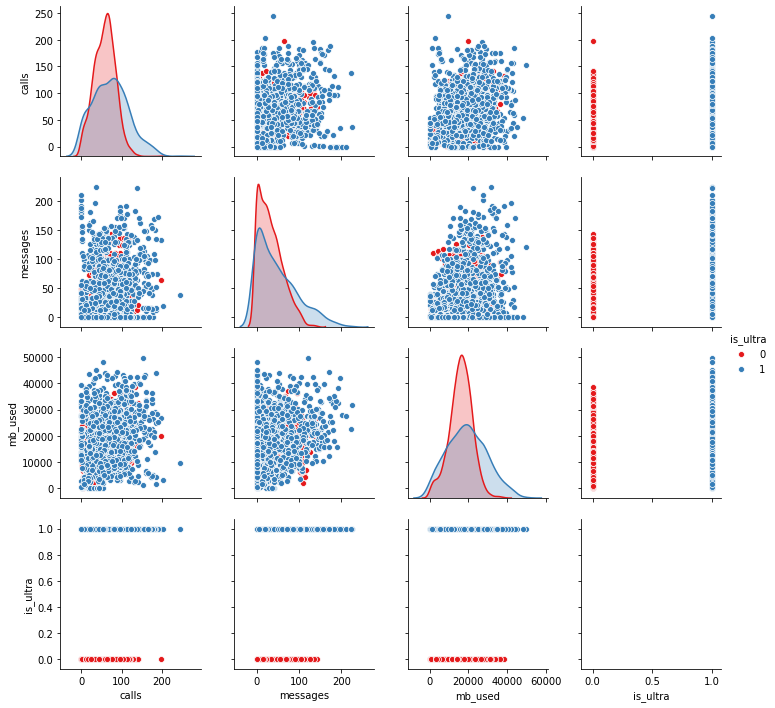

In [7]:
sns.pairplot(df, hue='is_ultra', palette='Set1')

<a id='section2'></a>

### 1.2. Подготовка данных

#### Обработаем дубликаты

Необходимо установить наличие дубликатов.

In [8]:
df.duplicated().sum()

0

Дубликатов в таблице не обнаружено.

#### Изменим тип даных некоторых столбцов с float на integer.

In [9]:
df['calls'] = df['calls'].astype(int)
df['messages'] = df['messages'].astype(int)

#### ВЫВОД 
На данном этапе проекта мы изучили данные о поведении клиентов оператора мобильной связи. Изучили коэффициенты корреляции, и выяснили, что звонки и минуты скоррелированы. Проверили данные на наличие пропусков и дубликатов. Изменили тип данных некоторых столбцов.

<a id='section3'></a>

## 2. Разбиение данных на выборки

### 2.1. Извлекаем в отдельные переменные признаки и целевой признак.

In [10]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

<a id='section4'></a>

### 2.2. Разделим наш набор данных на следующие выборки:
* 60% - обучающий набор,
* 20% - валидационный набор,
* 20% - тестовый набор.

In [11]:
#Выделим обучающую выборку 60%
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345, stratify=target)

In [12]:
#Разделим оставшиеся 40% на 2 равные части (валидационная и тестовая)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345, stratify=target_valid_test)

Выведем размеры выборок после их разбиения.

In [13]:
print('features_train:', features_train.shape)
print('target_train:', target_train.shape)
print('features_valid:', features_valid.shape)
print('target_valid:', target_valid.shape)
print('features_test:', features_test.shape)
print('target_test:', target_test.shape)

features_train: (1928, 3)
target_train: (1928,)
features_valid: (643, 3)
target_valid: (643,)
features_test: (643, 3)
target_test: (643,)


<a id='section5'></a>

## 3. Исследование моделей

### 3.1. Оценим качество трех моделей по умолчанию.

In [14]:
models = []
# для постоянства результата зададим random_state, равный 12345
models.append(('DTR', DecisionTreeClassifier(random_state=12345)))
models.append(('RFC', RandomForestClassifier(random_state=12345)))
models.append(('LR', LogisticRegression(random_state=12345)))

data = []
results = []
names = []
for name, model in models:
    model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predictions = model.predict(features_valid) # получаем предсказания модели на валидационной выборке
    result = accuracy_score(target_valid, predictions) # посчитаем качество модели
    results.append(result)
    names.append(name)
    data.append([name, result])
    
#сохраним результаты в отдельную таблицу
modl = pd.DataFrame(data, columns=['model', 'accuracy_default'])
modl  

,model,accuracy_default
0,DTR,0.715397
1,RFC,0.796267
2,LR,0.710731


*В оценке качества моделей по умолчанию лучшей стал алгоритм случайный лес (RandomForestClassifier). Оценим качество моделей и на тренировочной выборке, чтобы понять, насколько переобучается модель.*

<a id='section6'></a>

### 3.2. Оценим качество моделей на тренировочной выборке.

In [15]:
models = []
models.append(('DTR', DecisionTreeClassifier(random_state=12345)))
models.append(('RFC', RandomForestClassifier(random_state=12345)))
models.append(('LR', LogisticRegression(random_state=12345)))

data = []
results = []
names = []
for name, model in models:
    model.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predictions = model.predict(features_train) # получаем предсказания модели на тренировочной выборке
    result = accuracy_score(target_train, predictions) # посчитаем качество модели
    results.append(result)
    names.append(name)
    data.append([result])


#сохраним результаты в таблицу
modl['accuracy_train'] = pd.DataFrame(data)
modl  

,model,accuracy_default,accuracy_train
0,DTR,0.715397,1.000000
1,RFC,0.796267,0.979772
2,LR,0.710731,0.710581


*Мы видим, что модель Дерево решений переобучилась. Модель Случайного леса близка к переобучению, а вот модель Логистическая регрессия почти не изменилась.*

<a id='section7'></a>

### 3.3. Улучшим модели.

Настроим гиперпараметры разных моделей. Для этого нам необходимо перебрать разные значения по сетке GridSearchCV и сравнить качество моделей в разных вариантах.

<a id='section8'></a>

#### Случайный лес (RandomForestClassifier)

In [16]:
model_RFC = RandomForestClassifier(random_state=12345)

In [17]:
#Создаем сетку гиперпараметров
parametrs = { 'n_estimators': range (10, 50, 10),
              'max_depth': range (1,11,),
              'min_samples_leaf': range (1,11)}
grid = GridSearchCV(model_RFC, parametrs)

Запускаем обучение

In [18]:
#Посчитаем время обучения
start_time = time.time()

#Запускаем обучение
grid.fit(features_train, target_train)

#выводим потраченное время на обучение
print("--- %s seconds ---" % (time.time() - start_time))

--- 78.46976637840271 seconds ---


In [19]:
#Выводим результат
grid.best_params_

{'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 40}

In [20]:
#Обучаем модель RFC с лучшим гиперпараметрами
model_RFC = RandomForestClassifier(
    random_state=12345, n_estimators=30, max_depth=10, min_samples_leaf=2)
model_RFC.fit(features_train, target_train)
predictions_valid = model_RFC.predict(features_valid) 
accuracy = accuracy_score(target_valid, predictions_valid)
print('Качество RFC модели:', accuracy)

Качество RFC модели: 0.8195956454121306


<a id='section9'></a>

#### Дерево решений (DecisionTreeClassifier)

In [21]:
model_DTR=  DecisionTreeClassifier(random_state=12345)

In [22]:
#Создаем сетку гиперпараметров
parametrs = {'criterion':['gini','entropy'],
             'max_depth':range (1,11,)}
grid = GridSearchCV(model_DTR, parametrs)

In [23]:
#Запускаем обучение
grid.fit(features_train, target_train)
#Выводим результат
grid.best_params_

{'criterion': 'gini', 'max_depth': 7}

In [24]:
#Обучаем модель DTR с лучшим гиперпараметрами
model_DTR = DecisionTreeClassifier(random_state=12345, criterion='entropy', max_depth=3)
model_DTR.fit(features_train, target_train)
predictions_valid = model_DTR.predict(features_valid) 
accuracy = accuracy_score(target_valid, predictions_valid)
print('Качество DTR модели:', accuracy)

Качество DTR модели: 0.7993779160186625


<a id='section10'></a>

#### Логистическая регрессия (LogisticRegression)

In [25]:
model_LR = LogisticRegression(random_state=12345)

In [26]:
#Создаем сетку гиперпараметров
parametrs = {'C':range (1,20,), 'penalty':["l1","l2"]}
grid = GridSearchCV(model_LR, parametrs)

In [27]:
#Запускаем обучение
grid.fit(features_train, target_train)
#Выводим результат
grid.best_params_

{'C': 3, 'penalty': 'l1'}

In [28]:
#Обучаем модель LR с лучшим гиперпараметрами
model_LR = LogisticRegression(random_state=12345, C=1, penalty='l1')
model_LR.fit(features_train, target_train)
predictions_valid = model_LR.predict(features_valid) 
accuracy = accuracy_score(target_valid, predictions_valid)
print('Качество LR модели:', accuracy)

Качество LR модели: 0.7465007776049767


<a id='section11'></a>

### 3.4. Добавим получившиеся метрики в таблицу modl, и выберем лучшую модель.

In [29]:
modl['accuracy_improved']= [0.819595, 0.799377, 0.746500]
modl

,model,accuracy_default,accuracy_train,accuracy_improved
0,DTR,0.715397,1.000000,0.819595
1,RFC,0.796267,0.979772,0.799377
2,LR,0.710731,0.710581,0.746500


*По таблице можно сделать вывод, что лучше других с задачей справился метод RandomForest. Несмотря на то, что модель Дерево решения выдало результат с настроенными гиперпараметрами выше, чем у случайного леса, модель Дерево решения больше склонна к переобучению. Поэтому для дальнейшего анализа выберем модель Случайный лес (RandomForestClassifier).*

#### ВЫВОД 

На этапе исследования моделей, лучшей оказалась модель случайного леса (`RandomForestClassifier`). Для улучшения этой модели мы настроили гиперпараметры. Для этого перебрали разные значения по сетке GridSearchCV и сравнили качество моделей в разных вариантах. Затем обучили модель с лучшим значением `accuracy` на тренировочной выборке, и добились лучшего качества модели в 78%.

<a id='section12'></a>

## 4. Проверка модели на тестовой выборке

### 4.1. Объединим тренировачную и валидационную выборки.

In [30]:
features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])

<a id='section13'></a>

### 4.2. Обучим модель на полных данных.

In [31]:
model_RFC.fit(features_train_valid, target_train_valid)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

<a id='section14'></a>

### 4.3. Получим предсказания и посчитаем качество модели на тестовой выборке

In [32]:
predictions_test = model_RFC.predict(features_test) # получите предсказания модели
accuracy_test = accuracy_score(target_test, predictions_test) # посчитайте качество модели
accuracy_test

0.8133748055987559

*Качество финальной модели на тестовой выборке показало 81%.*

<a id='section15'></a>

## 5. Проверка модели на адекватность

### 5.1. Создадим константную модель.

In [33]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train_valid, target_train_valid)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(features_train_valid)
dummy_clf.score(features_train_valid, target_train_valid)

0.6935044729677169

<a id='section16'></a>

### 5.2. Сравним показатель точности константной модели и финальной.

In [34]:
print('accuracy_score константой модели:', dummy_clf.score(features_train_valid, target_train_valid))
print('accuracy_score финальной модели:', accuracy_score(target_test, predictions_test))

accuracy_score константой модели: 0.6935044729677169
accuracy_score финальной модели: 0.8133748055987559


*Финальная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной.*

<a id='section17'></a>

## 6. Общий вывод

На основе предоставленных нам данных, мы получили общее представление о поведении клиентов, которые перешли на новые тарифы «Смарт» и «Ультра». Нам необходимо было построить модель для задачи классификации, которая выберет подходящий тариф.
    
Для постройки модели мы использовали готовые библиотеки `Scikit-Learn`.
    
Сначала мы извлекли в отдельные переменные признаки и целевой признак.
    
Для построения предсказательной модели мы разбили исходные данные на обучающую, валидационную и тестовую выборки, в соотношении 60% – 20% – 20% объема исходных данных. Осуществили разделение данных методом `train_test_split()` и указали параметр `random_state`, равный 12345, для постоянства результата.
    
Следующим этапом нашей работы стало - исследование моделей. Мы оценили качество трех моделей, таких как, дерево решений, случайный лес и логистическая регрессия. Но оценки качества моделей по умолчанию нам недостаточно, поэтому мы оценили модель на обучающей выборке, а так же нам необходимо было улучшить модели путем изменения гиперпараметров. Для этого нам необходимо было перебрать разные значения по сетке `GridSearchCV` и сравнить качество моделей в разных вариантах.
    
Лучший результат показал алгоритм случайный лес (RandomForestClassifier). Несмотря на то, что модель Дерево решения выдало результат с настроенными гиперпараметрами выше, чем у случайного леса, модель Дерево решения больше склонна к переобучению. Поэтому для дальнейшего анализа выбрали модель Случайный лес (RandomForestClassifier). Качество данной модели составило 78%.
    
После этого, мы объединили тестовую и валидационную выборку и обучили модель на полных данных.
    
Далее, проверили модель на тестовой выборке. Качество финальной модели на тестовой выборке показало 81%.
    
И последним шагом, нам оставалось проверить модель на адекватность. Для этого необходимо было сравнить качество финальной модели с качеством наилучшей константной модели, в этом нам помог метод `DummyClassifier`. Финальная модель показала результаты лучше, чем константная модель, значит, финальную модель можно считать адекватной.
    
Таким образом, полученная модель поможет маркетологам лучше определять поведение клиентов и предложить пользователям новый тариф 'Смарт'.